In [ ]:
import os

from pyspark.sql import SparkSession
# Initialize Spark session
spark = SparkSession.builder \
    .appName("SpookyAuthorIdentification") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.maxResultSize", "12g") \
    .getOrCreate()


# Load the CSV data into a Spark DataFrame
file_path = "train.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Reduce the size of the dataframe
# This was done because the Machine Learning algorithms were taking very long to run on the original dataset
df = df.sample(fraction=0.5, seed=42)

# Show the schema and the first few rows of the Spark DataFrame
df.printSchema()
df.show(5, truncate=False)


root
 |-- id: string (nullable = true)
 |-- text: string (nullable = true)
 |-- author: string (nullable = true)

+-------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------+
|id     |text                                                                                                                                                                                                                                                                                                                                                |author|
+-------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
from pyspark.ml.feature import Tokenizer

# Tokenize the text column
tokenizer = Tokenizer(inputCol="text", outputCol="tokens")
df_tokens = tokenizer.transform(df)

# Show the tokenized text
df_tokens.select("tokens").show(5, truncate=False)


+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|tokens                                                                                                                                                                                                                                                                                                                                                                                                            |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
from pyspark.ml.feature import StopWordsRemover

# Customize stopwords list to include pronouns
stopwords = StopWordsRemover.loadDefaultStopWords("english") + ['I', 'you', 'he', 'she', 'it', 'we', 'they', 'me', 'him', 'her']

# Remove stopwords from the tokenized text
remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens", stopWords=stopwords)
df_cleaned = remover.transform(df_tokens)

# Show the cleaned tokens
df_cleaned.select("filtered_tokens").show(5, truncate=False)


+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|filtered_tokens                                                                                                                                                                                                                                    |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[lovely, spring, looked, windsor, terrace, sixteen, fertile, counties, spread, beneath,, speckled, happy, cottages, wealthier, towns,, looked, former, years,, heart, cheering, fair.]                                                             |
|[surcingle, hun

In [ ]:
#Stage 2 Feature Extraction

#import required functions
from pyspark.ml.feature import StopWordsRemover, Tokenizer
from pyspark.ml.feature import CountVectorizer, IDF
from pyspark.ml.feature import Normalizer
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from sklearn.decomposition import PCA

#TF-IDF calculation
vectorizer = CountVectorizer(inputCol="filtered_tokens", outputCol="vectorized_tokens")
idf = IDF(inputCol="vectorized_tokens", outputCol="tfidf")
normalizer = Normalizer(inputCol="tfidf", outputCol="normalized_features")

#The author column needed to be in numerical format for the machine learning algorithms later
indexer = StringIndexer(inputCol="author", outputCol="label")

#The dataframe has already gone through the tokenizer and remover steps at this point, so they don't need to
#be included in the pipeline
pipeline = Pipeline(stages=[vectorizer, idf, normalizer, indexer])

processed_data = pipeline.fit(df_cleaned).transform(df_cleaned)



In [ ]:
# Stage 3 Machine Learning

# Random Forest
from pyspark.ml.classification import RandomForestClassifier

# Split the data
train_data, test_data = processed_data.randomSplit([0.8, 0.2], seed=42)

# Random Forest
# Used 100 trees and the normalized_features column that was developed
rf = RandomForestClassifier(labelCol="label", featuresCol="normalized_features", numTrees=100)
rf_model = rf.fit(train_data)

predictions = rf_model.transform(test_data)



In [ ]:
# Logistic Regression
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import PCA

print(processed_data.printSchema())
pca = PCA(k=25, inputCol="normalized_features", outputCol="pca_features")
processed_data = pca.fit(processed_data).transform(processed_data)

#Used the normalized_features column and 100 iterations
logistic_regression = LogisticRegression(featuresCol="pca_features", labelCol="label", maxIter=50)

train_data, test_data = processed_data.randomSplit([0.8, 0.2], seed=42)


lr_model = logistic_regression.fit(train_data)

lr_predictions = lr_model.transform(test_data)

root
 |-- id: string (nullable = true)
 |-- text: string (nullable = true)
 |-- author: string (nullable = true)
 |-- tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered_tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- vectorized_tokens: vector (nullable = true)
 |-- tfidf: vector (nullable = true)
 |-- normalized_features: vector (nullable = true)
 |-- label: double (nullable = false)

None


ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pyspark/errors/exceptions/captured.py", line 179, in deco
    return f(*a, **kw)
  File "/usr/local/lib/python3.10/dist-packages/py4j/protocol.py", line 326, in get_return_value
    raise Py4JJavaError(
py4j.protocol.Py4JJavaError: <unprintable Py4JJavaError object>

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/lib/python

Py4JError: org.apache.spark.util does not exist in the JVM

In [ ]:
# Stage 4 Evaluation

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

# Random Forest Accuracy
accuracy = evaluator.evaluate(predictions)

print(f"Random Forest Accuracy = {accuracy:.2f}")

# Logistic Regression AccuracyLogistic Regression Accuracy =  0.60


lr_accuracy = evaluator.evaluate(lr_predictions)
print(f"Logistic Regression Accuracy =  {lr_accuracy:.2f}")

#The MulticlassClassificationEvaluator was used to evaluate the two models. The metric used was accuracy,
#because this is a classification problem. The prediction needs to be compared to the actual label, so the accuracy
#is the percentage of correct predictions.

#The Random Forest accuracy was only 36%. This is only 3% more than random chance, since there are only three authors.
#Although that's technically better than random chance, its not enough better to be ok with the results. This was with 100 trees.
#We also tried it with lower and more amounts of trees, but the results for accuracy were all similar.

#The Logistic Regression Accuracy was much better, at 60%. This was way better than the 33% for random chance.
#This was done with 50 iterations. We also tried with fewer iterations but that yielded worse results. Increasing
#The number of iterations did not improve accuracy by that much.

Random Forest Accuracy = 0.36
Logistic Regression Accuracy =  0.60


Logistic Regression - Accuracy: 0.65, Precision: 0.68, Recall: 0.65, F1 Score: 0.66
[0.0, 0.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 1.0, 4.0, 1.0, 2.0, 1.0, 0.0, 2.0, 0.0, 2.0, 1.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 1.0, 4.0, 4.0, 0.0, 0.0, 2.0, 1.0, 0.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 2.0, 0.0, 1.0, 1.0, 4.0, 1.0, 0.0, 2.0, 1.0, 0.0, 4.0, 0.0, 2.0, 2.0, 1.0, 0.0, 1.0, 2.0, 0.0, 4.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 2.0, 2.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 0.0, 1.0, 0.0, 2.0, 0.0, 2.0, 0.0, 1.0, 0.0, 1.0, 1.0, 2.0, 2.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 2.0, 4.0, 2.0, 1.0, 4.0, 2.0, 1.0, 1.0, 0.0, 0.0, 2.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 4.0, 2.0, 0.0, 2.0, 0.0, 1.0, 0.0, 0.0, 4.0, 2.0, 0.0, 1.0, 0.0, 4.0, 2.0, 0.0, 0.0, 0.0, 2.0, 2.0, 2.0, 0.0, 4.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 2.0, 1.0, 4.0, 1.0, 0.0, 2.0, 0.0, 1.0, 4.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 

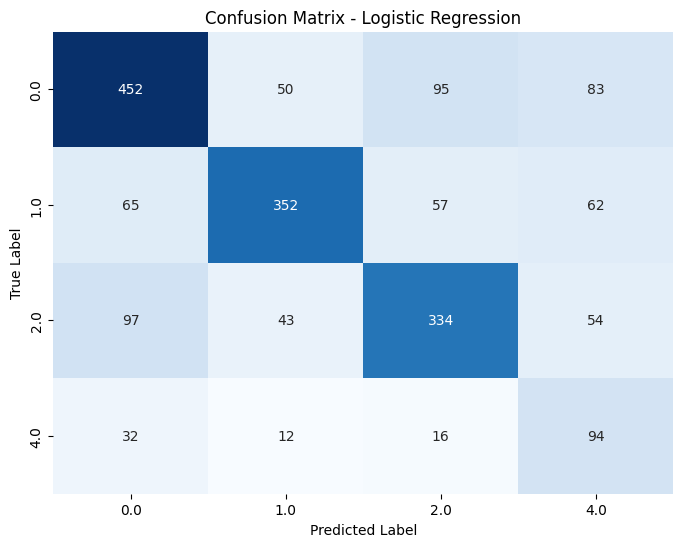

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.sql.functions import when

# instantiates evaluators for different metrics
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
evaluator_precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

# model eval: logistic regression
lr_accuracy = evaluator_accuracy.evaluate(lr_predictions)
lr_precision = evaluator_precision.evaluate(lr_predictions)
lr_recall = evaluator_recall.evaluate(lr_predictions)
lr_f1 = evaluator_f1.evaluate(lr_predictions)

print(f"Logistic Regression - Accuracy: {lr_accuracy:.2f}, Precision: {lr_precision:.2f}, Recall: {lr_recall:.2f}, F1 Score: {lr_f1:.2f}")

# confusion matrix (logistic regression)
y_true = lr_predictions.select("label").rdd.flatMap(lambda x: x).collect()
y_pred = lr_predictions.select("prediction").rdd.flatMap(lambda x: x).collect()

lr_predictions = lr_predictions.withColumn("prediction", when(lr_predictions["prediction"] > 2.0, 4.0).otherwise(lr_predictions["prediction"]))
lr_predictions = lr_predictions.withColumn("label", when(lr_predictions["label"] > 2.0, 4.0).otherwise(lr_predictions["label"]))

metrics = MulticlassMetrics(lr_predictions.select("prediction", "label").rdd.map(tuple))
confusion_matrix = metrics.confusionMatrix().toArray()
unique_labels = lr_predictions.select("label").distinct().rdd.flatMap(lambda x: x).collect()
unique_labels_sorted = sorted(unique_labels)
print(unique_labels_sorted)
confusion_df = pd.DataFrame(confusion_matrix, index=unique_labels_sorted, columns=unique_labels_sorted)


# confusion matrix visualization
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_df, annot=True, fmt="g", cmap="Blues", cbar=False)
plt.title("Confusion Matrix - Logistic Regression")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

#Because the Logistic Regression model performed the best out of the two models, with an accuracy score of .6, we decided
#to evaluate other performance metrics on this model. The model had a Precision of .65, Recall of .6, and F1 score of .62.
#The F1 score ranges from 0 to 1, with 0 being the worst and 1 being the best. Our F1 score of .62 is above average, and indicates
#the model is doing a good job of making predictions. The precision and recall scores are also on a 0 to 1 scale, so the model
#is above average on those as well. All four of these metrics indicate that the model is doing much better than simple random chance
#at classification of the authors for the given texts.

#Next steps for this process would be to maybe perform PCA analysis on the data and then incorporate the findings into the models
#themselves. This might help increase the accuracy of the models by focusing more on which components are most contributing to the
#classification of the texts.

#The Confusion Matrix is based on the results of the Logistic Regression model. The three authors from the dataset were represented by 0, 1, and 2
#due to the string indexing done earlier in the data preprocessing step. The Logistic Regression model requires numerical data, so the Author Names
#needed to be represented by numerical values. As such, any prediction by the model that was not a 0, 1, or 2 was an incorrect prediction. However,
#the model used many different numbers for incorrect predictions so we changed all of these to just a 4 for the visualization. The values along the
#diagonal of the confusion matrix represent the correct predictions, excluding the 4,4 box. So, the 0,0 and 1,1 and 2,2 values are the correct predictions.


